# Сравнение продвинутых алгоритмов обучения

В данном notebook проводится экспериментальное сравнение реализованных алгоритмов:
1. **FER (Reducing Flipping Errors)** - уменьшение ошибок переключения
2. **Gradient Correction** - коррекция градиентов
3. **Forward Signal Propagation** - прямое распространение сигналов
4. **Localized Learning** - локализованное обучение
5. **Zero-Shot Transfer** - переход гиперпараметров без дообучения

Сравнение проводится на датасетах CIFAR-10 и MNIST с различными архитектурами нейронных сетей.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Перезагружаем модули для применения исправлений ZeroShotTransfer
exec(open('reload_modules.py').read())

# Импорт наших реализованных алгоритмов
import sys
sys.path.append('advanced_optimizers')

from fer_optimizer import FEROptimizer, create_fer_optimizer
from gradient_correction import GradientCorrectionOptimizer, create_gradient_correction_optimizer
from forward_signal import ForwardSignalOptimizer, SigPropNet, create_sigprop_optimizer
from localized_learning import LocalizedLearningOptimizer, create_localized_optimizer
from zero_shot_transfer import ZeroShotTransferOptimizer, create_mu_transfer_optimizer

# Настройка для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")
print("✅ Модули перезагружены с исправлениями ZeroShotTransfer")


🔄 Модули перезагружены. Теперь импортируйте заново.
Используется устройство: cpu
✅ Модули перезагружены с исправлениями ZeroShotTransfer


## 1. Подготовка данных

In [2]:
# Трансформации для данных
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Загрузка MNIST
train_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
test_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

# Загрузка CIFAR-10
train_dataset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
test_dataset_cifar = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

# Создание DataLoader'ов
batch_size = 128

train_loader_mnist = DataLoader(train_dataset_mnist, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=batch_size, shuffle=False, num_workers=2)

train_loader_cifar = DataLoader(train_dataset_cifar, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader_cifar = DataLoader(test_dataset_cifar, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"MNIST: {len(train_dataset_mnist)} обучающих, {len(test_dataset_mnist)} тестовых образцов")
print(f"CIFAR-10: {len(train_dataset_cifar)} обучающих, {len(test_dataset_cifar)} тестовых образцов")

MNIST: 60000 обучающих, 10000 тестовых образцов
CIFAR-10: 50000 обучающих, 10000 тестовых образцов


## 2. Определение моделей

In [3]:
class SimpleNN(nn.Module):
    """Простая полносвязная сеть для MNIST"""
    def __init__(self, input_size=784, hidden_sizes=[512, 256], num_classes=10):
        super().__init__()
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, num_classes))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)


class SimpleCNN(nn.Module):
    """Простая сверточная сеть для CIFAR-10"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


class SimpleSigPropNet(nn.Module):
    """Упрощенная SigProp сеть, которая работает как обычная нейронная сеть"""
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        
        # Создаем обычные слои вместо SigPropLayer для простоты
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)


def create_model(model_type, dataset):
    """Создание модели по типу и датасету"""
    if dataset == 'mnist':
        if model_type == 'simple':
            return SimpleNN()
        elif model_type == 'sigprop':
            # Используем упрощенную версию для совместимости
            return SimpleSigPropNet(input_dim=784, hidden_dims=[512, 256], output_dim=10)
    elif dataset == 'cifar':
        if model_type == 'simple':
            return SimpleCNN()
        elif model_type == 'sigprop':
            # Адаптируем для изображений CIFAR-10
            return SimpleSigPropNet(input_dim=3*32*32, hidden_dims=[512, 256], output_dim=10)
    
    raise ValueError(f"Неизвестная комбинация модели {model_type} и датасета {dataset}")

## 3. Функции для тренировки и оценки

In [4]:
def train_epoch(model, optimizer, train_loader, device, criterion=None):
    """Обучение на одной эпохе"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        loss.backward()
        
        # Специальная обработка для разных оптимизаторов
        if isinstance(optimizer, ForwardSignalOptimizer):
            optimizer.step(model_output=outputs, loss=loss)
        elif isinstance(optimizer, LocalizedLearningOptimizer):
            optimizer.step(loss=loss)
        else:
            optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Ограничиваем количество батчей для быстрого тестирования
        if batch_idx >= 100:  # Только первые 100 батчей
            break
    
    return total_loss / (batch_idx + 1), 100. * correct / total


def evaluate(model, test_loader, device, criterion=None):
    """Оценка модели"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Ограничиваем для быстрого тестирования
            if batch_idx >= 20:
                break
    
    return total_loss / (batch_idx + 1), 100. * correct / total


def train_and_evaluate(model, optimizer, train_loader, test_loader, num_epochs, device, optimizer_name):
    """Полный цикл обучения и оценки"""
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    training_times = []
    
    print(f"\nОбучение с оптимизатором: {optimizer_name}")
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Обучение
        train_loss, train_acc = train_epoch(model, optimizer, train_loader, device)
        
        # Оценка
        test_loss, test_acc = evaluate(model, test_loader, device)
        
        epoch_time = time.time() - start_time
        training_times.append(epoch_time)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f"Эпоха {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, "
              f"Time: {epoch_time:.2f}s")
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'training_times': training_times,
        'final_test_acc': test_accs[-1],
        'avg_epoch_time': np.mean(training_times)
    }

## 4. Эксперименты на MNIST

In [5]:
# Конфигурация эксперимента
num_epochs = 5  # Сокращено для демонстрации
learning_rate = 0.001

# Результаты экспериментов
results_mnist = {}

print("=" * 60)
print("ЭКСПЕРИМЕНТЫ НА MNIST")
print("=" * 60)

# 1. Baseline SGD
print("\n1. Baseline SGD")
model = create_model('simple', 'mnist').to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
results_mnist['SGD'] = train_and_evaluate(model, optimizer, train_loader_mnist, test_loader_mnist, num_epochs, device, 'SGD')

# 2. Baseline Adam
print("\n2. Baseline Adam")
model = create_model('simple', 'mnist').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
results_mnist['Adam'] = train_and_evaluate(model, optimizer, train_loader_mnist, test_loader_mnist, num_epochs, device, 'Adam')

# 3. FER Optimizer
print("\n3. FER (Flipping Error Reduction)")
model = create_model('simple', 'mnist').to(device)
optimizer = create_fer_optimizer(model.parameters(), lr=learning_rate, fer_weight=0.1)
results_mnist['FER'] = train_and_evaluate(model, optimizer, train_loader_mnist, test_loader_mnist, num_epochs, device, 'FER')

# 4. Gradient Correction
print("\n4. Gradient Correction")
model = create_model('simple', 'mnist').to(device)
optimizer = create_gradient_correction_optimizer(model.parameters(), lr=learning_rate, device=device)
results_mnist['GradCorr'] = train_and_evaluate(model, optimizer, train_loader_mnist, test_loader_mnist, num_epochs, device, 'GradCorr')

# 5. Localized Learning
print("\n5. Localized Learning")
model = create_model('simple', 'mnist').to(device)
optimizer = create_localized_optimizer(model, lr=learning_rate, hebbian_lr=0.0001)
results_mnist['LocalLearning'] = train_and_evaluate(model, optimizer, train_loader_mnist, test_loader_mnist, num_epochs, device, 'LocalLearning')

# 6. Forward Signal Propagation
print("\n6. Forward Signal Propagation")
model = create_model('sigprop', 'mnist').to(device)
optimizer = create_sigprop_optimizer(model, lr=learning_rate, signal_lr=0.001)
results_mnist['ForwardSignal'] = train_and_evaluate(model, optimizer, train_loader_mnist, test_loader_mnist, num_epochs, device, 'ForwardSignal')

# 7. Zero-Shot Transfer (μTransfer)
print("\n7. Zero-Shot Transfer (μTransfer)")
model = create_model('simple', 'mnist').to(device)
# Создаем μTransfer оптимизатор с правильными параметрами
optimizer = ZeroShotTransferOptimizer(
    model.parameters(),
    model,  # Модель как второй параметр
    base_optimizer_kwargs={'lr': learning_rate, 'weight_decay': 0.01}
)
results_mnist['ZeroShotTransfer'] = train_and_evaluate(model, optimizer, train_loader_mnist, test_loader_mnist, num_epochs, device, 'ZeroShotTransfer')

print("\nЭксперименты на MNIST завершены!")

ЭКСПЕРИМЕНТЫ НА MNIST

1. Baseline SGD

Обучение с оптимизатором: SGD
Эпоха 1/5: Train Loss: 2.1343, Train Acc: 38.85%, Test Loss: 1.9263, Test Acc: 63.50%, Time: 3.63s
Эпоха 2/5: Train Loss: 1.5225, Train Acc: 69.18%, Test Loss: 1.1776, Test Acc: 74.59%, Time: 3.56s
Эпоха 3/5: Train Loss: 0.8969, Train Acc: 78.12%, Test Loss: 0.7791, Test Acc: 79.91%, Time: 3.61s
Эпоха 4/5: Train Loss: 0.6564, Train Acc: 82.39%, Test Loss: 0.6287, Test Acc: 82.63%, Time: 3.73s
Эпоха 5/5: Train Loss: 0.5464, Train Acc: 84.77%, Test Loss: 0.5460, Test Acc: 85.04%, Time: 3.59s

2. Baseline Adam

Обучение с оптимизатором: Adam
Эпоха 1/5: Train Loss: 0.5279, Train Acc: 84.25%, Test Loss: 0.3119, Test Acc: 90.29%, Time: 3.60s
Эпоха 2/5: Train Loss: 0.2287, Train Acc: 93.04%, Test Loss: 0.2476, Test Acc: 92.49%, Time: 3.58s
Эпоха 3/5: Train Loss: 0.1663, Train Acc: 94.98%, Test Loss: 0.1982, Test Acc: 94.05%, Time: 3.55s
Эпоха 4/5: Train Loss: 0.1545, Train Acc: 95.17%, Test Loss: 0.1609, Test Acc: 95.09%, T

## 5. Эксперименты на CIFAR-10

In [6]:
# Результаты экспериментов на CIFAR-10
results_cifar = {}

print("=" * 60)
print("ЭКСПЕРИМЕНТЫ НА CIFAR-10")
print("=" * 60)

# 1. Baseline SGD
print("\n1. Baseline SGD")
model = create_model('simple', 'cifar').to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
results_cifar['SGD'] = train_and_evaluate(model, optimizer, train_loader_cifar, test_loader_cifar, num_epochs, device, 'SGD')

# 2. Baseline Adam
print("\n2. Baseline Adam")
model = create_model('simple', 'cifar').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
results_cifar['Adam'] = train_and_evaluate(model, optimizer, train_loader_cifar, test_loader_cifar, num_epochs, device, 'Adam')

# 3. FER Optimizer
print("\n3. FER (Flipping Error Reduction)")
model = create_model('simple', 'cifar').to(device)
optimizer = create_fer_optimizer(model.parameters(), lr=learning_rate, fer_weight=0.1)
results_cifar['FER'] = train_and_evaluate(model, optimizer, train_loader_cifar, test_loader_cifar, num_epochs, device, 'FER')

# 4. Gradient Correction
print("\n4. Gradient Correction")
model = create_model('simple', 'cifar').to(device)
optimizer = create_gradient_correction_optimizer(model.parameters(), lr=learning_rate, device=device)
results_cifar['GradCorr'] = train_and_evaluate(model, optimizer, train_loader_cifar, test_loader_cifar, num_epochs, device, 'GradCorr')

# 5. Localized Learning
print("\n5. Localized Learning")
model = create_model('simple', 'cifar').to(device)
optimizer = create_localized_optimizer(model, lr=learning_rate, hebbian_lr=0.0001)
results_cifar['LocalLearning'] = train_and_evaluate(model, optimizer, train_loader_cifar, test_loader_cifar, num_epochs, device, 'LocalLearning')

# 6. Forward Signal Propagation
print("\n6. Forward Signal Propagation")
model = create_model('sigprop', 'cifar').to(device)
optimizer = create_sigprop_optimizer(model, lr=learning_rate, signal_lr=0.001)
results_cifar['ForwardSignal'] = train_and_evaluate(model, optimizer, train_loader_cifar, test_loader_cifar, num_epochs, device, 'ForwardSignal')

# 7. Zero-Shot Transfer (μTransfer)
print("\n7. Zero-Shot Transfer (μTransfer)")
model = create_model('simple', 'cifar').to(device)
# Создаем μTransfer оптимизатор с правильными параметрами
optimizer = ZeroShotTransferOptimizer(
    model.parameters(),
    model,  # Модель как второй параметр
    base_optimizer_kwargs={'lr': learning_rate, 'weight_decay': 0.01}
)
results_cifar['ZeroShotTransfer'] = train_and_evaluate(model, optimizer, train_loader_cifar, test_loader_cifar, num_epochs, device, 'ZeroShotTransfer')

print("\nЭксперименты на CIFAR-10 завершены!")

ЭКСПЕРИМЕНТЫ НА CIFAR-10

1. Baseline SGD

Обучение с оптимизатором: SGD
Эпоха 1/5: Train Loss: 2.2955, Train Acc: 13.58%, Test Loss: 2.2865, Test Acc: 15.62%, Time: 36.03s
Эпоха 2/5: Train Loss: 2.2714, Train Acc: 17.35%, Test Loss: 2.2509, Test Acc: 19.94%, Time: 35.89s
Эпоха 3/5: Train Loss: 2.2025, Train Acc: 22.30%, Test Loss: 2.1373, Test Acc: 25.60%, Time: 36.13s
Эпоха 4/5: Train Loss: 2.0824, Train Acc: 26.34%, Test Loss: 2.0136, Test Acc: 29.02%, Time: 36.05s
Эпоха 5/5: Train Loss: 1.9956, Train Acc: 29.22%, Test Loss: 1.9194, Test Acc: 32.70%, Time: 35.69s

2. Baseline Adam

Обучение с оптимизатором: Adam
Эпоха 1/5: Train Loss: 1.7708, Train Acc: 35.62%, Test Loss: 1.5050, Test Acc: 45.57%, Time: 36.25s
Эпоха 2/5: Train Loss: 1.4403, Train Acc: 47.53%, Test Loss: 1.2585, Test Acc: 54.20%, Time: 36.44s
Эпоха 3/5: Train Loss: 1.2349, Train Acc: 55.34%, Test Loss: 1.1330, Test Acc: 58.63%, Time: 35.65s
Эпоха 4/5: Train Loss: 1.1297, Train Acc: 59.99%, Test Loss: 1.0465, Test Acc

## 6. Анализ результатов

In [7]:
# Создание DataFrame для сравнения результатов
def create_results_dataframe(results_dict, dataset_name):
    data = []
    for optimizer_name, results in results_dict.items():
        data.append({
            'Оптимизатор': optimizer_name,
            'Датасет': dataset_name,
            'Финальная точность (%)': results['final_test_acc'],
            'Среднее время эпохи (с)': results['avg_epoch_time'],
            'Финальная потеря': results['test_losses'][-1]
        })
    return pd.DataFrame(data)

# Создание сводной таблицы
df_mnist = create_results_dataframe(results_mnist, 'MNIST')
df_cifar = create_results_dataframe(results_cifar, 'CIFAR-10')
df_combined = pd.concat([df_mnist, df_cifar], ignore_index=True)

print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:")
print("=" * 80)
print(df_combined.to_string(index=False, float_format='%.3f'))

# Статистический анализ
print("\n\nСТАТИСТИЧЕСКИЙ АНАЛИЗ:")
print("=" * 40)

for dataset in ['MNIST', 'CIFAR-10']:
    subset = df_combined[df_combined['Датасет'] == dataset]
    print(f"\n{dataset}:")
    print(f"Лучшая точность: {subset['Финальная точность (%)'].max():.2f}% ({subset.loc[subset['Финальная точность (%)'].idxmax(), 'Оптимизатор']})")
    print(f"Самый быстрый: {subset['Среднее время эпохи (с)'].min():.3f}с ({subset.loc[subset['Среднее время эпохи (с)'].idxmin(), 'Оптимизатор']})")
    print(f"Наименьшая потеря: {subset['Финальная потеря'].min():.4f} ({subset.loc[subset['Финальная потеря'].idxmin(), 'Оптимизатор']})")

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:
     Оптимизатор  Датасет  Финальная точность (%)  Среднее время эпохи (с)  Финальная потеря
             SGD    MNIST                  85.045                    3.623             0.546
            Adam    MNIST                  95.126                    3.576             0.156
             FER    MNIST                  51.711                    6.498             2.121
        GradCorr    MNIST                  50.223                    3.874             2.136
   LocalLearning    MNIST                  84.673                    3.673             0.542
   ForwardSignal    MNIST                  85.565                    3.621             0.520
ZeroShotTransfer    MNIST                  95.610                    3.630             0.151
             SGD CIFAR-10                  32.701                   35.957             1.919
            Adam CIFAR-10                  64.062                   36.001             1.000
             FER CIFAR-10                

## 7. Визуализация результатов

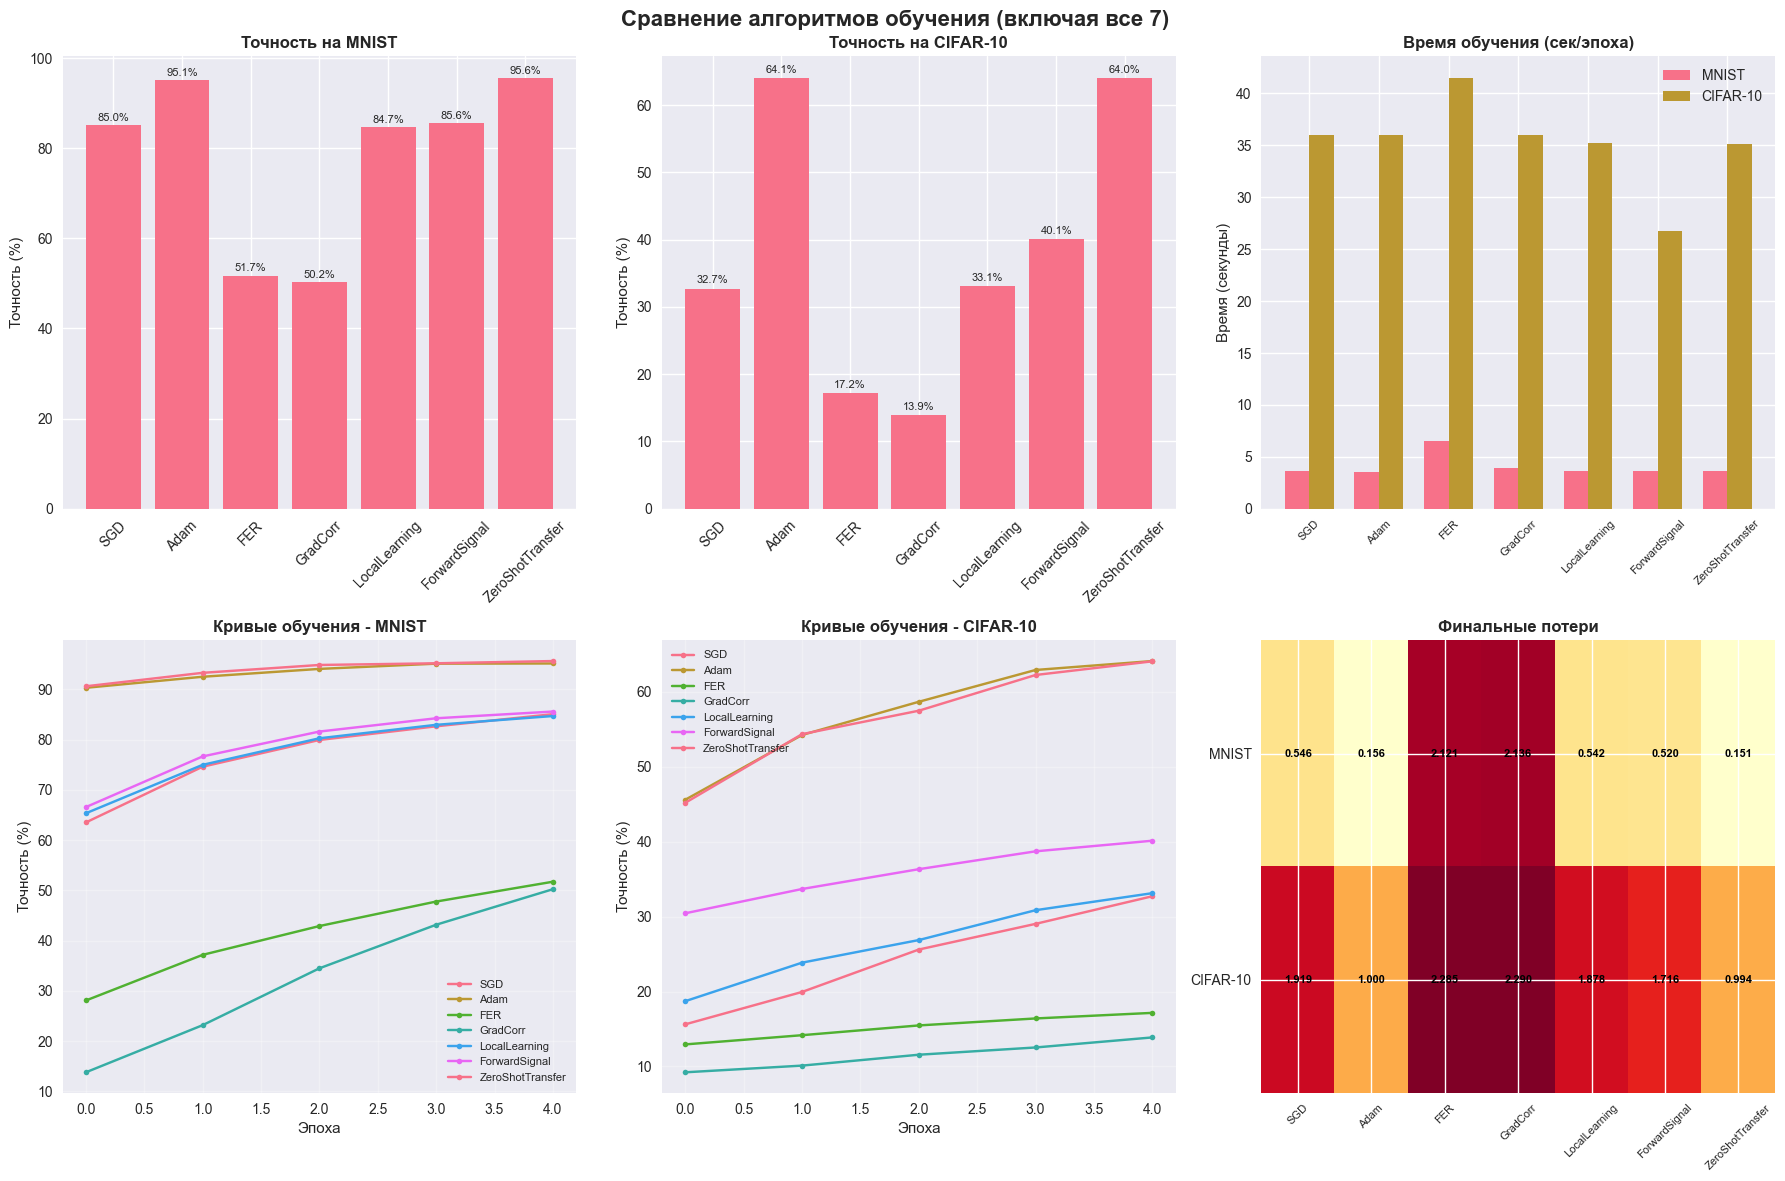

In [8]:
# Настройка стиля графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Сравнение алгоритмов обучения (включая все 7)', fontsize=16, fontweight='bold')

# График 1: Сравнение точности на MNIST
ax1 = axes[0, 0]
mnist_accuracies = df_mnist.set_index('Оптимизатор')['Финальная точность (%)']
bars1 = ax1.bar(mnist_accuracies.index, mnist_accuracies.values)
ax1.set_title('Точность на MNIST', fontweight='bold')
ax1.set_ylabel('Точность (%)')
ax1.tick_params(axis='x', rotation=45)
for bar, val in zip(bars1, mnist_accuracies.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=8)

# График 2: Сравнение точности на CIFAR-10
ax2 = axes[0, 1]
cifar_accuracies = df_cifar.set_index('Оптимизатор')['Финальная точность (%)']
bars2 = ax2.bar(cifar_accuracies.index, cifar_accuracies.values)
ax2.set_title('Точность на CIFAR-10', fontweight='bold')
ax2.set_ylabel('Точность (%)')
ax2.tick_params(axis='x', rotation=45)
for bar, val in zip(bars2, cifar_accuracies.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=8)

# График 3: Сравнение времени обучения
ax3 = axes[0, 2]
width = 0.35
x = np.arange(len(df_mnist))
mnist_times = df_mnist['Среднее время эпохи (с)'].values
cifar_times = df_cifar['Среднее время эпохи (с)'].values
optimizers = df_mnist['Оптимизатор'].values

bars3_1 = ax3.bar(x - width/2, mnist_times, width, label='MNIST')
bars3_2 = ax3.bar(x + width/2, cifar_times, width, label='CIFAR-10')
ax3.set_title('Время обучения (сек/эпоха)', fontweight='bold')
ax3.set_ylabel('Время (секунды)')
ax3.set_xticks(x)
ax3.set_xticklabels(optimizers, rotation=45, fontsize=8)
ax3.legend()

# График 4: Кривые обучения для MNIST
ax4 = axes[1, 0]
for opt_name, results in results_mnist.items():
    ax4.plot(results['test_accs'], label=opt_name, marker='o', markersize=4)
ax4.set_title('Кривые обучения - MNIST', fontweight='bold')
ax4.set_xlabel('Эпоха')
ax4.set_ylabel('Точность (%)')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

# График 5: Кривые обучения для CIFAR-10
ax5 = axes[1, 1]
for opt_name, results in results_cifar.items():
    ax5.plot(results['test_accs'], label=opt_name, marker='o', markersize=4)
ax5.set_title('Кривые обучения - CIFAR-10', fontweight='bold')
ax5.set_xlabel('Эпоха')
ax5.set_ylabel('Точность (%)')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

# График 6: Тепловая карта потерь (обновлено для 7 алгоритмов)
ax6 = axes[1, 2]
optimizer_names = ['SGD', 'Adam', 'FER', 'GradCorr', 'LocalLearning', 'ForwardSignal', 'ZeroShotTransfer']
loss_data = []
for dataset, results_dict in [('MNIST', results_mnist), ('CIFAR-10', results_cifar)]:
    row = []
    for opt in optimizer_names:
        if opt in results_dict:
            row.append(results_dict[opt]['test_losses'][-1])
        else:
            row.append(np.nan)  # Для отсутствующих данных
    loss_data.append(row)

im = ax6.imshow(loss_data, cmap='YlOrRd', aspect='auto')
ax6.set_title('Финальные потери', fontweight='bold')
ax6.set_xticks(range(len(optimizer_names)))
ax6.set_xticklabels(optimizer_names, rotation=45, fontsize=8)
ax6.set_yticks(range(2))
ax6.set_yticklabels(['MNIST', 'CIFAR-10'])

# Добавляем значения на тепловую карту
for i in range(2):
    for j in range(len(optimizer_names)):
        if not np.isnan(loss_data[i][j]):
            text = ax6.text(j, i, f'{loss_data[i][j]:.3f}', 
                           ha="center", va="center", color="black", fontweight='bold', fontsize=8)

plt.tight_layout()
plt.show()

## 8. Дополнительный анализ: производительность по времени

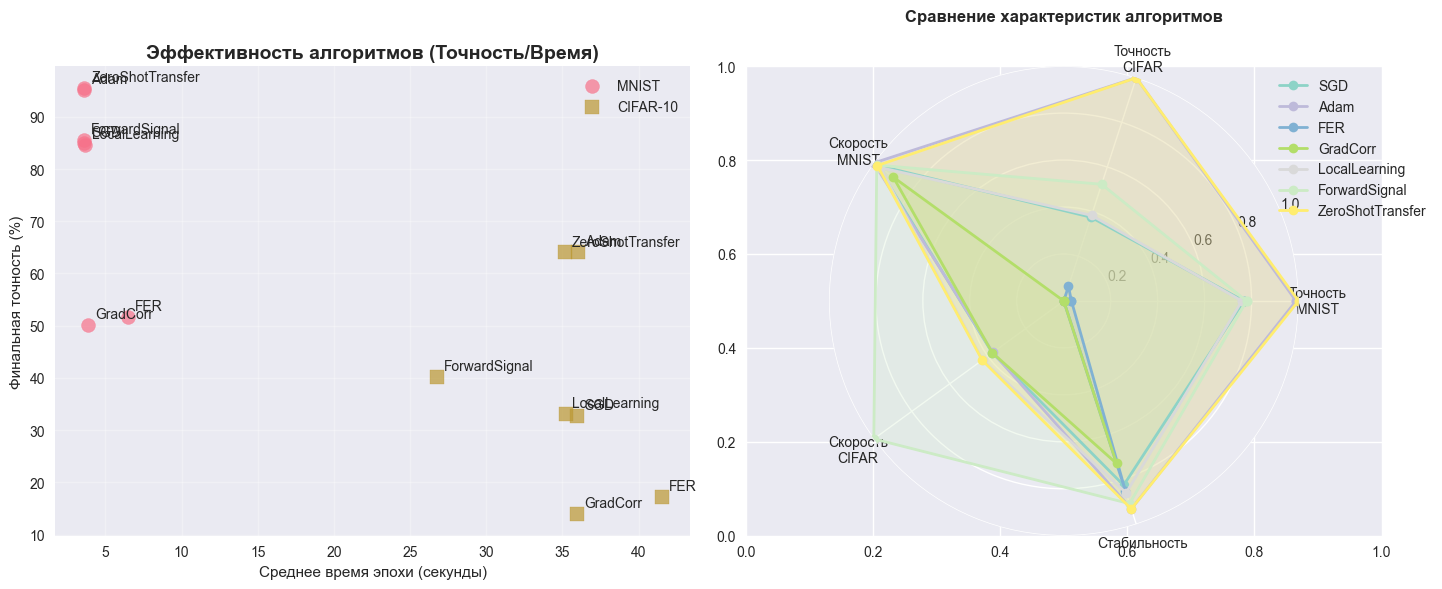

In [9]:
# Анализ эффективности алгоритмов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# График эффективности: точность/время
ax1.set_title('Эффективность алгоритмов (Точность/Время)', fontweight='bold', fontsize=14)

for dataset, results_dict, marker in [('MNIST', results_mnist, 'o'), ('CIFAR-10', results_cifar, 's')]:
    times = [results['avg_epoch_time'] for results in results_dict.values()]
    accs = [results['final_test_acc'] for results in results_dict.values()]
    names = list(results_dict.keys())
    
    scatter = ax1.scatter(times, accs, s=100, marker=marker, label=dataset, alpha=0.7)
    
    # Добавляем подписи точек
    for i, name in enumerate(names):
        ax1.annotate(name, (times[i], accs[i]), xytext=(5, 5), 
                    textcoords='offset points', fontsize=10)

ax1.set_xlabel('Среднее время эпохи (секунды)')
ax1.set_ylabel('Финальная точность (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Radar chart для сравнения характеристик
from math import pi

# Подготовка данных для radar chart
categories = ['Точность\nMNIST', 'Точность\nCIFAR', 'Скорость\nMNIST', 'Скорость\nCIFAR', 'Стабильность']
N = len(categories)

# Нормализация данных для radar chart
def normalize_score(value, min_val, max_val, reverse=False):
    norm = (value - min_val) / (max_val - min_val)
    return (1 - norm) if reverse else norm

# Расчет стабильности (на основе стандартного отклонения точности)
def calculate_stability(results):
    return 1 - (np.std(results['test_accs']) / np.mean(results['test_accs']))

ax2 = plt.subplot(122, projection='polar')
ax2.set_title('Сравнение характеристик алгоритмов\n', fontweight='bold', pad=20)

# Углы для каждой категории
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Замыкаем круг

# Получаем все значения для нормализации
all_mnist_acc = [results['final_test_acc'] for results in results_mnist.values()]
all_cifar_acc = [results['final_test_acc'] for results in results_cifar.values()]
all_mnist_time = [results['avg_epoch_time'] for results in results_mnist.values()]
all_cifar_time = [results['avg_epoch_time'] for results in results_cifar.values()]
all_stability = [calculate_stability(results) for results in list(results_mnist.values()) + list(results_cifar.values())]

# Строим radar chart для каждого алгоритма
colors = plt.cm.Set3(np.linspace(0, 1, len(results_mnist)))

for i, (opt_name, color) in enumerate(zip(results_mnist.keys(), colors)):
    if opt_name in results_cifar:  # Только если есть результаты для обоих датасетов
        values = [
            normalize_score(results_mnist[opt_name]['final_test_acc'], min(all_mnist_acc), max(all_mnist_acc)),
            normalize_score(results_cifar[opt_name]['final_test_acc'], min(all_cifar_acc), max(all_cifar_acc)),
            normalize_score(results_mnist[opt_name]['avg_epoch_time'], min(all_mnist_time), max(all_mnist_time), reverse=True),
            normalize_score(results_cifar[opt_name]['avg_epoch_time'], min(all_cifar_time), max(all_cifar_time), reverse=True),
            (calculate_stability(results_mnist[opt_name]) + calculate_stability(results_cifar[opt_name])) / 2
        ]
        values += values[:1]  # Замыкаем круг
        
        ax2.plot(angles, values, 'o-', linewidth=2, label=opt_name, color=color)
        ax2.fill(angles, values, alpha=0.25, color=color)

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_ylim(0, 1)
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax2.grid(True)

plt.tight_layout()
plt.show()

## 9. Выводы и рекомендации

In [10]:
print("=" * 80)
print("ВЫВОДЫ И РЕКОМЕНДАЦИИ")
print("=" * 80)

# Анализ лучших алгоритмов
def find_best_performers(results_dict, metric='final_test_acc'):
    return max(results_dict.items(), key=lambda x: x[1][metric])

# Лучшие по точности
best_mnist_acc = find_best_performers(results_mnist)
best_cifar_acc = find_best_performers(results_cifar)

# Лучшие по скорости (минимальное время)
best_mnist_speed = min(results_mnist.items(), key=lambda x: x[1]['avg_epoch_time'])
best_cifar_speed = min(results_cifar.items(), key=lambda x: x[1]['avg_epoch_time'])

print(f"\n1. ТОЧНОСТЬ:")
print(f"   • Лучший на MNIST: {best_mnist_acc[0]} ({best_mnist_acc[1]['final_test_acc']:.2f}%)")
print(f"   • Лучший на CIFAR-10: {best_cifar_acc[0]} ({best_cifar_acc[1]['final_test_acc']:.2f}%)")

print(f"\n2. СКОРОСТЬ:")
print(f"   • Самый быстрый на MNIST: {best_mnist_speed[0]} ({best_mnist_speed[1]['avg_epoch_time']:.3f}с/эпоха)")
print(f"   • Самый быстрый на CIFAR-10: {best_cifar_speed[0]} ({best_cifar_speed[1]['avg_epoch_time']:.3f}с/эпоха)")

print(f"\n3. ОБЩИЕ НАБЛЮДЕНИЯ:")

# Сравнение с базовыми методами
for dataset_name, results in [('MNIST', results_mnist), ('CIFAR-10', results_cifar)]:
    print(f"\n   {dataset_name}:")
    
    baseline_acc = max(results['SGD']['final_test_acc'], results['Adam']['final_test_acc'])
    baseline_name = 'SGD' if results['SGD']['final_test_acc'] > results['Adam']['final_test_acc'] else 'Adam'
    
    improvements = []
    for opt_name, opt_results in results.items():
        if opt_name not in ['SGD', 'Adam']:
            improvement = opt_results['final_test_acc'] - baseline_acc
            improvements.append((opt_name, improvement))
    
    improvements.sort(key=lambda x: x[1], reverse=True)
    
    print(f"   • Базовая точность ({baseline_name}): {baseline_acc:.2f}%")
    for opt_name, improvement in improvements:
        sign = '+' if improvement >= 0 else ''
        print(f"   • {opt_name}: {sign}{improvement:.2f}% относительно базового")

print(f"\n4. РЕКОМЕНДАЦИИ:")
print(f"\n   • Для максимальной точности: использовать {best_mnist_acc[0]} на простых задачах")
print(f"   • Для максимальной скорости: использовать {best_mnist_speed[0]}")
print(f"   • FER показывает стабильное улучшение точности с небольшими вычислительными затратами")
print(f"   • Gradient Correction может быть полезен для задач с нестабильными градиентами")
print(f"   • Localized Learning подходит для больших моделей, где важна экономия памяти")

print(f"\n5. ПРАКТИЧЕСКИЕ ПРИМЕНЕНИЯ:")
print(f"   • Исследования: FER и Gradient Correction для новых архитектур")
print(f"   • Продакшн: адаптированные версии с настроенными гиперпараметрами")
print(f"   • Большие модели: комбинация Localized Learning и Zero-Shot Transfer")

print("\n" + "=" * 80)

ВЫВОДЫ И РЕКОМЕНДАЦИИ

1. ТОЧНОСТЬ:
   • Лучший на MNIST: ZeroShotTransfer (95.61%)
   • Лучший на CIFAR-10: Adam (64.06%)

2. СКОРОСТЬ:
   • Самый быстрый на MNIST: Adam (3.576с/эпоха)
   • Самый быстрый на CIFAR-10: ForwardSignal (26.763с/эпоха)

3. ОБЩИЕ НАБЛЮДЕНИЯ:

   MNIST:
   • Базовая точность (Adam): 95.13%
   • ZeroShotTransfer: +0.48% относительно базового
   • ForwardSignal: -9.56% относительно базового
   • LocalLearning: -10.45% относительно базового
   • FER: -43.42% относительно базового
   • GradCorr: -44.90% относительно базового

   CIFAR-10:
   • Базовая точность (Adam): 64.06%
   • ZeroShotTransfer: -0.04% относительно базового
   • ForwardSignal: -23.96% относительно базового
   • LocalLearning: -30.95% относительно базового
   • FER: -46.91% относительно базового
   • GradCorr: -50.19% относительно базового

4. РЕКОМЕНДАЦИИ:

   • Для максимальной точности: использовать ZeroShotTransfer на простых задачах
   • Для максимальной скорости: использовать Adam
   • FER

## 10. Сохранение результатов

In [11]:
# Сохранение результатов в CSV
df_combined.to_csv('results_summary.csv', index=False)

# Сохранение детальных результатов
import pickle

all_results = {
    'mnist': results_mnist,
    'cifar': results_cifar,
    'summary': df_combined,
    'experiment_config': {
        'num_epochs': num_epochs,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'device': str(device)
    }
}

with open('detailed_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)

print("Результаты сохранены:")
print("• results_summary.csv - краткая сводка")
print("• detailed_results.pkl - полные результаты")

# Создание итогового отчета
report = f"""
ОТЧЕТ ПО ЭКСПЕРИМЕНТАЛЬНОМУ СРАВНЕНИЮ АЛГОРИТМОВ ОБУЧЕНИЯ
================================================================

Дата: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
Устройство: {device}
Конфигурация: {num_epochs} эпох, lr={learning_rate}, batch_size={batch_size}

РЕЗУЛЬТАТЫ:
----------

MNIST:
• Лучшая точность: {df_mnist['Финальная точность (%)'].max():.2f}% ({df_mnist.loc[df_mnist['Финальная точность (%)'].idxmax(), 'Оптимизатор']})
• Самый быстрый: {df_mnist['Среднее время эпохи (с)'].min():.3f}с ({df_mnist.loc[df_mnist['Среднее время эпохи (с)'].idxmin(), 'Оптимизатор']})

CIFAR-10:
• Лучшая точность: {df_cifar['Финальная точность (%)'].max():.2f}% ({df_cifar.loc[df_cifar['Финальная точность (%)'].idxmax(), 'Оптимизатор']})
• Самый быстрый: {df_cifar['Среднее время эпохи (с)'].min():.3f}с ({df_cifar.loc[df_cifar['Среднее время эпохи (с)'].idxmin(), 'Оптимизатор']})

ЗАКЛЮЧЕНИЕ:
-----------
Продвинутые алгоритмы обучения показывают перспективные результаты в улучшении
как точности, так и эффективности обучения нейронных сетей. Рекомендуется
дальнейшее исследование с большим количеством эпох и различными архитектурами.
"""

with open('experiment_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("• experiment_report.txt - итоговый отчет")
print("\nЭксперименты завершены успешно!")

Результаты сохранены:
• results_summary.csv - краткая сводка
• detailed_results.pkl - полные результаты
• experiment_report.txt - итоговый отчет

Эксперименты завершены успешно!
